In [1]:

import arviz as az
import pymc as py
import pandas as pd
import numpy as np
from datafunction import *
import aesara.tensor as at
from aesara import function
import seaborn as sns


In [2]:
TGW_df = pd.read_csv('TransformedData/GWF.csv')
TGW_df.sample(5)

,Unnamed: 0,name,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,GW_step,kickoff_time_t_step,Tally_Points_step,was_home_ind,was_home_step_ind,ind_DEF,ind_FWD,ind_GK,ind_MID,playtime
8306,342461,Rúben Diogo da Silva Neves,Wolves,2.8,0,0,13,0,18.2,436,...,28,2022-03-05T15:00:00Z,40,0,1,0,0,0,1,1
17661,716363,Erik Lamela,Spurs,0.0,0,0,0,0,0.0,356,...,7,2021-10-03T13:00:00Z,12,0,1,0,0,0,1,0
18572,753715,Saman Ghoddos,Brentford,0.2,0,0,0,0,0.0,85,...,30,2022-03-20T14:00:00Z,30,1,0,0,0,0,1,0
9488,389420,Douglas Luiz Soares de Paulo,Aston Villa,4.0,0,0,16,1,11.9,50,...,9,2021-10-22T19:00:00Z,10,1,0,0,0,0,1,1
6551,270265,Alexandre Lacazette,Arsenal,3.3,0,0,5,0,12.1,6,...,33,2022-04-16T14:00:00Z,54,1,0,0,1,0,0,1


In [3]:
# Isolate what we need from this dependant variables

depend = TGW_df[[
            'GW'                                                    # Gameweek
            ,'playtime'                                             # this is an indicator function
            ,'xP'                                                   # this is an XP approach, i actually don't know what it means
            ,'transfers_balance', 'transfers_in', 'transfers_out'   # have to standardize this
            ,'ind_DEF', 'ind_FWD','ind_MID'                         #Position of players
            ,'was_home_ind'                                         # currently was this a home game?
            ,'was_home_step_ind'                                    # temporily this information is available to use
            ,'value'                                                # Current value of the player
            ,'total_points'                                         # Current performance of the player
            ,'Tally_Points'                                         # Points collected so far, need to rework this
            #,'value'                                                # Value of player
            ,'total_points_step'                                    #
            ]]



In [15]:
# transform vars
depend['value'].describe()
#np.log(depend['transfers_in'])

count    30206.000000
mean        50.804211
std         12.479906
min         37.000000
25%         44.000000
50%         47.000000
75%         54.000000
max        133.000000
Name: value, dtype: float64

In [5]:
def total_point_correction(row):
    # for row wise computation
    '''
    To correct issue with -ve points which is not condusive to my model
    '''

    if row <0:
        result = 0
    else:
        result = row
    return result

explain = depend['total_points_step'].apply(total_point_correction)


In [16]:
with py.Model() as TotalPointsModel:

    #define priors as weekly 
    intercept = py.Normal("intercept", mu=0, sigma=10)
    value = py.Normal("value", mu= 50,sigma=20)            #based on a quick spot check of graphs.ipynb domain is positive
    # transfers_out = py.Normal("transfers_out", mu= 3,sigma=10)
    # transfers_in = py.Normal("transfers_in", mu= 3,sigma=10)

    # our linear model 
    # theta = b0 +b1 * T1['value'] + b2 *T1['transfers_out'] + b3 *T1['transfers_in']
    theta = at.dscalar('theta')
    

    theta = intercept + value * depend['value'].values #+ transfers_out * depend['transfers_out'].values + transfers_in * depend['transfers_in'].values  
    
    #f = function([b0,b1,b2,b3],theta)
    

    # define poisson likelihood
    y = py.Poisson("y", mu=py.math.log(theta), observed = (explain.values  ))  # one step ahead dependency forward
    

In [17]:
# sns.kdeplot(data=depend['transfers_out'])
#help(intercept)
y
# myiter =iter(intercept)
#next(myiter)



y

In [18]:
with TotalPointsModel:
    thetaSample = py.sample() 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, value]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 557 seconds.
There were 511 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.159, but should be close to 0.8. Try to increase the number of tuning steps.
There were 359 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3098, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9554, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 576 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1426, but should be close to 0.8. Try to increase t

In [13]:
thetaSample

# thetaSample.posterior['intercept'].mean() 

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<AxesSubplot:>

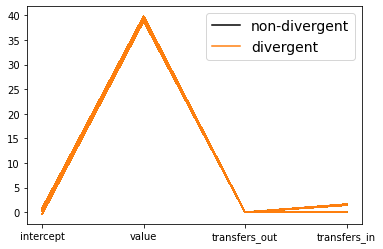

In [10]:
az.plot_parallel(thetaSample) # plotting this 

In [36]:
import aesara
a = aesara.tensor.vector() # declare variable
b = at.vector()
out = a **2 +b**2 +2*a*b               # build symbolic expression
f = aesara.function([a ,b], out)   # compile function
print(f([0, 1, 2],[0,1,2]))

[ 0.  4. 16.]


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'value'}>]], dtype=object)

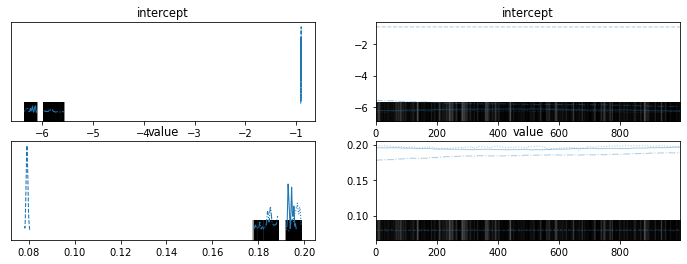

In [19]:
az.plot_trace(thetaSample) # wow that does not look good.